# **Introduction**
**This project is part of Deep Learning/Computer Vision projects in Benha Faculty of Computers and AI (BFCAI)**

*Optical Character Recognition (OCR) is one of the critical tasks of computer vision and Artificial Intelligence, due to variety of languages written, variety of fonts for the same languages. our task is to make OCR and text detection for `English` texts*

*- our used dataset is `OCR-Dataset` which contains more than `200000` images for alphanumeric characters in both upper and lowercase*
*- our target is to detect **LOWERCASE** characters only in the text which are used in the project*

> Dataset was generated using 3475 font styles available in Google Fonts. Each alphanumeric character (uppercase, lowercase and numerals) was generated in each font style and stored in a directory. Total dataset size: 2.1 lakh images for 62 classes [OCR-Dataset](https://www.kaggle.com/datasets/harieh/ocr-dataset/)

![](https://www.cheggindia.com/wp-content/uploads/2023/08/ocr-full-form.png)

## **Table of Content**
### *1. Importing Libraries*
### *2. Helper Functions & Hyperparameters*
### *3. Reading & preparing the dataset*
### *4. Modeling*
### *5. Evaluation & Comparison*
### *6. Post-processing*
### *7. Conclusion*

# 1) Importing Libraries

In [547]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

# 2) Helper Functions & Hyperparameters

- **This section to define all Helper functions through the notebook and any hyperparameters used later for training the models**

In [500]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.h5',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [553]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

# 3) Reading & preparing the dataset

In [6]:
# Reading the dataset in dataframe 
main_path = '/kaggle/input/ocr-dataset/dataset'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 85199


,image,label
0,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1241...,c
1,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3096...,c
2,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3184...,c
3,/kaggle/input/ocr-dataset/dataset/c_L/C_L_2981...,c
4,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1635...,c


In [7]:
df['label'].value_counts()

label
r    3284
e    3284
n    3281
a    3281
m    3281
q    3279
u    3278
i    3277
d    3277
y    3276
x    3276
s    3276
l    3276
k    3276
t    3276
g    3275
w    3275
h    3275
z    3275
f    3275
p    3275
o    3275
b    3274
c    3274
j    3274
v    3274
Name: count, dtype: int64

## 3.1) Splitting the dataframe
- The dataframe is splitted to get 70% of the dataset for `training` , and 30% for `testing`
- The training set is splitted into `training` and `validation` to enhance the model training

In [8]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [9]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

## 3.2) Creating generators
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also, it enhance the RAM usage.

In [10]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [11]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

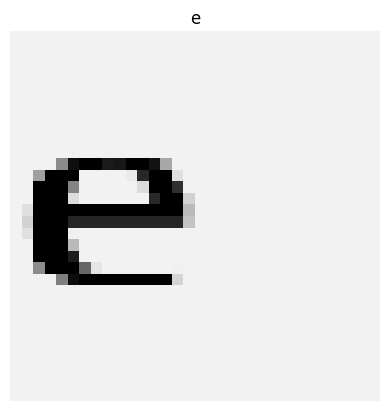

The shape of the image: (32, 32, 3)


In [503]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

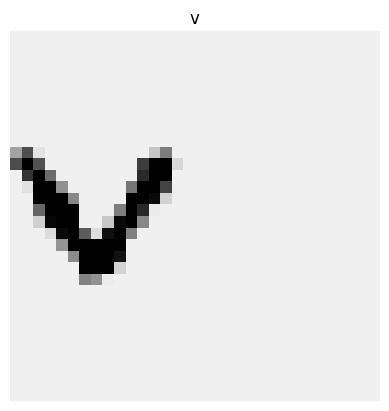

The shape of the image: (32, 32, 3)


In [504]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

# 4) Modeling
*Our target is to build a **`custom CNN model`** to train on our targeted images for the `OCR` application. in advance, we also will use 4 Pre-trained models as part of `Transfer Learning` and to enhance the performance of the application.*

***Our targeted pretrained models are the following:***

*- EfficientNetB7*

*- MobileNetV2*

*- VGG19*

*- DenseNet121*

***The fine-tuning strategy:*** *using a small value of `LR` of the optimizer `Adam` will make an efficient use of the pre-trained models on our dataset without **FREEZING** the input layers in which better performance is required in our case*

## 4.1) Custom CNN

In [511]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [512]:
CNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (32, 32, 32, 3)           84        
                                                                 
 conv2d_23 (Conv2D)          (32, 30, 30, 128)         3584      
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 10, 10, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (32, 8, 8, 256)           295168    
                                                                 
 dropout_7 (Dropout)         (32, 8, 8, 256)           0         
                                                                 
 conv2d_25 (Conv2D)          (32, 4, 4, 256)           590080    
                                                      

In [513]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [515]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20


2023-12-19 01:26:16.313547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1398/1398 [==============================] - ETA: 0s - loss: 1.4546 - accuracy: 0.6006
Epoch 1: val_loss improved from inf to 0.55987, saving model to CustomCnn_model.h5
1398/1398 [==============================] - 100s 69ms/step - loss: 1.4546 - accuracy: 0.6006 - val_loss: 0.5599 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1397/1398 [============================>.] - ETA: 0s - loss: 0.5372 - accuracy: 0.8516
Epoch 2: val_loss improved from 0.55987 to 0.42339, saving model to CustomCnn_model.h5
1398/1398 [==============================] - 61s 44ms/step - loss: 0.5374 - accuracy: 0.8515 - val_loss: 0.4234 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 3/20
1397/1398 [============================>.] - ETA: 0s - loss: 0.4275 - accuracy: 0.8821
Epoch 3: val_loss did not improve from 0.42339
1398/1398 [==============================] - 62s 44ms/step - loss: 0.4275 - accuracy: 0.8821 - val_loss: 0.4371 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 4/20
1398/1398 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8969
Epoch 4: val_loss improved from 0.42339 to 0.33205, saving model to CustomCnn_model.h5
1398/1398 [==============================] - 63s 45ms/step - loss: 0.3766 - accuracy: 0.8969 - val_loss: 0.3320 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 5/20
1398/1398 [==============================

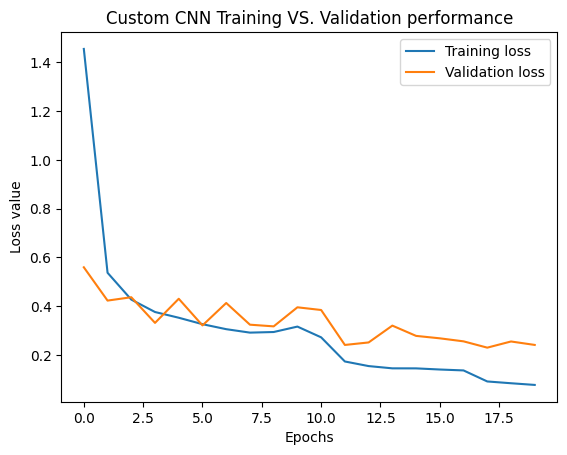

In [516]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [517]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 [==============================] - 46s 58ms/step


In [518]:
print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           a       0.94      0.95      0.95       992
           b       0.96      0.97      0.97       929
           c       0.96      0.94      0.95      1008
           d       0.98      0.94      0.96       999
           e       0.91      0.94      0.93       973
           f       0.92      0.97      0.94      1000
           g       0.97      0.94      0.96       957
           h       0.97      0.94      0.95       973
           i       0.95      0.95      0.95       969
           j       0.98      0.97      0.97       931
           k       0.94      0.98      0.96      1000
           l       0.92      0.96      0.94       974
           m       0.98      0.97      0.97      1005
           n       0.92      0.96      0.94       951
           o       0.94      0.95      0.94       951
           p       0.96      0.97      0.96       982
           q       0.97      0.96      0.

## 4.2) EfficientNetB7

In [519]:
# EfficientNetB7 input layers will not be FREEZED
train_layers = EfficientNetB7(include_top=False, input_shape=IMG_SIZE)
EffNetB7 = Sequential()
EffNetB7.add(train_layers)
EffNetB7.add(Flatten())
EffNetB7.add(Dense(1024, activation='selu'))
EffNetB7.add(Dropout(0.2))
EffNetB7.add(Dense(512, activation='selu'))
EffNetB7.add(Dense(len(mapping), activation='softmax'))

258076736/258076736 [==============================] - 2s 0us/step


In [520]:
EffNetB7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 1, 1, 2560)        64097687  
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 2560)              0         
                                                                 
 dense_9 (Dense)             (None, 1024)              2622464   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 26)                13338     
                                                      

In [521]:
# The pre-defined optimizer will be used with too small learning rate
EffNetB7.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [522]:
history2 = EffNetB7.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck("EfficientNetB7"))

Epoch 1/10


2023-12-19 01:50:06.171579: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1398/1398 [==============================] - ETA: 0s - loss: 2.5019 - accuracy: 0.2948
Epoch 1: val_loss improved from inf to 2.12889, saving model to EfficientNetB7_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 359s 159ms/step - loss: 2.5019 - accuracy: 0.2948 - val_loss: 2.1289 - val_accuracy: 0.3930 - lr: 1.0000e-05
Epoch 2/10
1398/1398 [==============================] - ETA: 0s - loss: 1.3608 - accuracy: 0.6111
Epoch 2: val_loss improved from 2.12889 to 1.23930, saving model to EfficientNetB7_model.h5
1398/1398 [==============================] - 218s 156ms/step - loss: 1.3608 - accuracy: 0.6111 - val_loss: 1.2393 - val_accuracy: 0.6431 - lr: 1.0000e-05
Epoch 3/10
1398/1398 [==============================] - ETA: 0s - loss: 0.9424 - accuracy: 0.7323
Epoch 3: val_loss improved from 1.23930 to 0.72789, saving model to EfficientNetB7_model.h5
1398/1398 [==============================] - 217s 156ms/step - loss: 0.9424 - accuracy: 0.7323 - val_loss: 0.7279 - val_accuracy: 0.7973 - lr: 1.0000e-05
Epoch 4/10
1398/1398 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.7951
Epoch 4: val_loss improved from 0.72789 to 0.50908, saving m

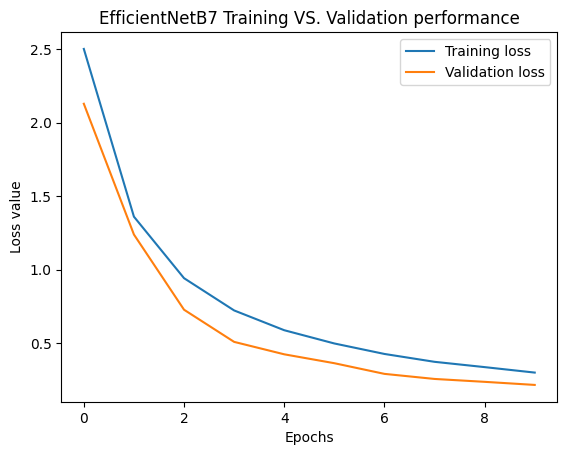

In [523]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("EfficientNetB7 Training VS. Validation performance")
plt.show()

In [524]:
# Making a prediction out of the EfficientNetB7 for the testing set for the evaluation
prediction = EffNetB7.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 [==============================] - 55s 62ms/step


In [531]:
print('\t     The EfficientNetB7 Evaluation Performance')
print(classification_report(y_test, pred))

	     The EfficientNetB7 Evaluation Performance
              precision    recall  f1-score   support

           a       0.88      0.93      0.90       992
           b       0.93      0.95      0.94       929
           c       0.95      0.91      0.93      1008
           d       0.98      0.94      0.96       999
           e       0.91      0.89      0.90       973
           f       0.96      0.94      0.95      1000
           g       0.94      0.91      0.92       957
           h       0.92      0.93      0.93       973
           i       0.93      0.90      0.91       969
           j       0.98      0.93      0.95       931
           k       0.94      0.95      0.94      1000
           l       0.89      0.94      0.91       974
           m       0.94      0.97      0.95      1005
           n       0.93      0.92      0.93       951
           o       0.91      0.96      0.94       951
           p       0.98      0.94      0.96       982
           q       0.94      0.95

## 4.3) MobileNetV2

In [534]:
# MobileNetV2 input layers will not be FREEZED
train_layers = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
MobNetV2 = Sequential()
MobNetV2.add(train_layers)
MobNetV2.add(Flatten())
MobNetV2.add(Dense(1024, activation='selu'))
MobNetV2.add(Dropout(0.2))
MobNetV2.add(Dense(512, activation='selu'))
MobNetV2.add(Dense(len(mapping), activation='softmax'))

In [535]:
MobNetV2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1, 1, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 1024)              1311744   
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               524800    
                                                                 
 dense_17 (Dense)            (None, 26)                13338     
                                                      

In [539]:
MobNetV2.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [540]:
history3 = MobNetV2.fit(train_gen, epochs=EPOCHS, validation_data=valid_gen, callbacks=clbck('MobileNetV2'))

Epoch 1/10
1398/1398 [==============================] - ETA: 0s - loss: 3.5094 - accuracy: 0.1240
Epoch 1: val_loss improved from inf to 3.27014, saving model to MobileNetV2_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 144s 84ms/step - loss: 3.5094 - accuracy: 0.1240 - val_loss: 3.2701 - val_accuracy: 0.0734 - lr: 1.0000e-05
Epoch 2/10
1398/1398 [==============================] - ETA: 0s - loss: 2.6365 - accuracy: 0.2728
Epoch 2: val_loss improved from 3.27014 to 2.75422, saving model to MobileNetV2_model.h5
1398/1398 [==============================] - 66s 48ms/step - loss: 2.6365 - accuracy: 0.2728 - val_loss: 2.7542 - val_accuracy: 0.2171 - lr: 1.0000e-05
Epoch 3/10
1397/1398 [============================>.] - ETA: 0s - loss: 2.2481 - accuracy: 0.3582
Epoch 3: val_loss improved from 2.75422 to 2.13160, saving model to MobileNetV2_model.h5
1398/1398 [==============================] - 67s 48ms/step - loss: 2.2476 - accuracy: 0.3583 - val_loss: 2.1316 - val_accuracy: 0.3769 - lr: 1.0000e-05
Epoch 4/10
1398/1398 [==============================] - ETA: 0s - loss: 1.9450 - accuracy: 0.4354
Epoch 4: val_loss improved from 2.13160 to 1.77245, saving model to Mob

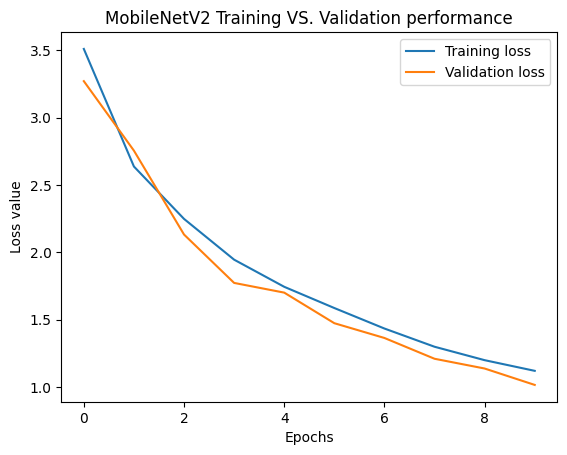

In [541]:
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("MobileNetV2 Training VS. Validation performance")
plt.show()

In [542]:
# Making a prediction out of the MobileNetV2 for the testing set for the evaluation
prediction = MobNetV2.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 [==============================] - 50s 61ms/step


In [543]:
print('\t     The MobileNetV2 Evaluation Performance')
print(classification_report(y_test, pred))

	     The MobileNetV2 Evaluation Performance
              precision    recall  f1-score   support

           a       0.61      0.57      0.59       992
           b       0.42      0.76      0.54       929
           c       0.66      0.64      0.65      1008
           d       0.73      0.72      0.73       999
           e       0.67      0.67      0.67       973
           f       0.69      0.64      0.67      1000
           g       0.75      0.69      0.72       957
           h       0.77      0.61      0.68       973
           i       0.67      0.64      0.65       969
           j       0.79      0.80      0.80       931
           k       0.82      0.78      0.80      1000
           l       0.79      0.74      0.77       974
           m       0.83      0.86      0.84      1005
           n       0.62      0.71      0.66       951
           o       0.78      0.77      0.78       951
           p       0.71      0.81      0.76       982
           q       0.67      0.57   

## 4.4) VGG19

In [549]:
# VGG19 input layers will not be FREEZED
train_layers = VGG19(include_top=False, input_shape=IMG_SIZE)
VG = Sequential()
VG.add(train_layers)
VG.add(Flatten())
VG.add(Dense(1024, activation='selu'))
VG.add(Dense(512, activation='selu'))
VG.add(Dense(len(mapping), activation='softmax'))

In [550]:
VG.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 1024)              525312    
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dense_23 (Dense)            (None, 26)                13338     
                                                                 
Total params: 21087834 (80.44 MB)
Trainable params: 21087834 (80.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [554]:
VG.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [555]:
history4 = VG.fit(train_gen, validation_data=valid_gen, epochs=EPOCHS, callbacks=clbck('VGG19'))

Epoch 1/10
1398/1398 [==============================] - ETA: 0s - loss: 1.0711 - accuracy: 0.7773
Epoch 1: val_loss improved from inf to 0.50163, saving model to VGG19_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 119s 81ms/step - loss: 1.0711 - accuracy: 0.7773 - val_loss: 0.5016 - val_accuracy: 0.8920 - lr: 1.0000e-05
Epoch 2/10
1397/1398 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.9115
Epoch 2: val_loss improved from 0.50163 to 0.32387, saving model to VGG19_model.h5
1398/1398 [==============================] - 63s 45ms/step - loss: 0.3631 - accuracy: 0.9115 - val_loss: 0.3239 - val_accuracy: 0.9281 - lr: 1.0000e-05
Epoch 3/10
1398/1398 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.9305
Epoch 3: val_loss improved from 0.32387 to 0.26054, saving model to VGG19_model.h5
1398/1398 [==============================] - 64s 46ms/step - loss: 0.2661 - accuracy: 0.9305 - val_loss: 0.2605 - val_accuracy: 0.9385 - lr: 1.0000e-05
Epoch 4/10
1398/1398 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.9431
Epoch 4: val_loss improved from 0.26054 to 0.23723, saving model to VGG19_model.h5


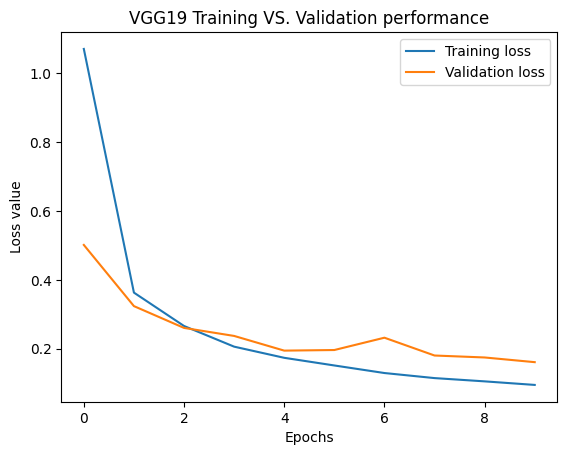

In [556]:
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("VGG19 Training VS. Validation performance")
plt.show()

In [557]:
# Making a prediction out of the VGG19 for the testing set for the evaluation
prediction = VG.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 [==============================] - 47s 59ms/step


In [559]:
print('\t\tThe VGG19 Evaluation Performance')
print(classification_report(y_test, pred))

		The VGG19 Evaluation Performance
              precision    recall  f1-score   support

           a       0.87      0.96      0.92       992
           b       0.95      0.97      0.96       929
           c       0.99      0.90      0.94      1008
           d       0.96      0.98      0.97       999
           e       0.93      0.95      0.94       973
           f       0.96      0.97      0.96      1000
           g       0.95      0.95      0.95       957
           h       0.95      0.97      0.96       973
           i       0.95      0.95      0.95       969
           j       0.99      0.95      0.97       931
           k       0.98      0.97      0.97      1000
           l       0.94      0.96      0.95       974
           m       0.99      0.97      0.98      1005
           n       0.96      0.94      0.95       951
           o       0.93      0.95      0.94       951
           p       0.97      0.97      0.97       982
           q       0.97      0.95      0.96   

## 4.5) DenseNet121 

In [13]:
# DenseNset121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

29084464/29084464 [==============================] - 0s 0us/step


In [14]:
Den.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 26)                13338     
                                                                 
Total params: 8625242 (32.90 MB)
Trainable params: 8541594 (32.58 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [15]:
Den.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [16]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=10, callbacks=clbck("DenseNet121"))

Epoch 1/10
1398/1398 [==============================] - ETA: 0s - loss: 1.8124 - accuracy: 0.5082
Epoch 1: val_loss improved from inf to 0.80502, saving model to DenseNet121_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 333s 187ms/step - loss: 1.8124 - accuracy: 0.5082 - val_loss: 0.8050 - val_accuracy: 0.7805 - lr: 1.0000e-05
Epoch 2/10
1398/1398 [==============================] - ETA: 0s - loss: 0.7938 - accuracy: 0.7770
Epoch 2: val_loss improved from 0.80502 to 0.46235, saving model to DenseNet121_model.h5
1398/1398 [==============================] - 120s 86ms/step - loss: 0.7938 - accuracy: 0.7770 - val_loss: 0.4623 - val_accuracy: 0.8729 - lr: 1.0000e-05
Epoch 3/10
1398/1398 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.8409
Epoch 3: val_loss improved from 0.46235 to 0.34170, saving model to DenseNet121_model.h5
1398/1398 [==============================] - 123s 88ms/step - loss: 0.5588 - accuracy: 0.8409 - val_loss: 0.3417 - val_accuracy: 0.9042 - lr: 1.0000e-05
Epoch 4/10
1398/1398 [==============================] - ETA: 0s - loss: 0.4395 - accuracy: 0.8748
Epoch 4: val_loss improved from 0.34170 to 0.29790, saving model to 

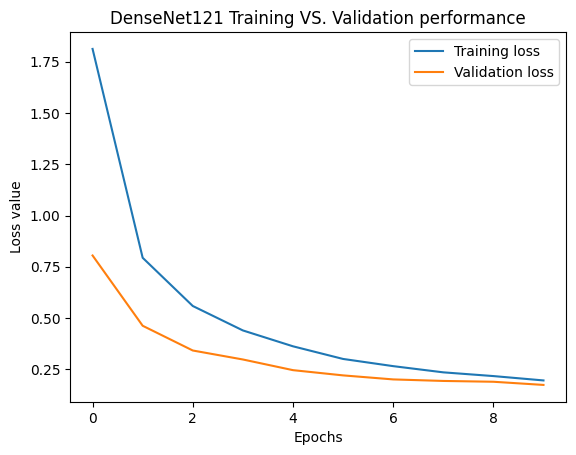

In [17]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [560]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

799/799 [==============================] - 24s 30ms/step


In [561]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

		The DenseNet121 Evaluation Performance
              precision    recall  f1-score   support

           a       0.89      0.95      0.92       992
           b       0.96      0.96      0.96       929
           c       0.94      0.93      0.94      1008
           d       0.98      0.95      0.97       999
           e       0.91      0.93      0.92       973
           f       0.97      0.96      0.96      1000
           g       0.96      0.91      0.93       957
           h       0.97      0.94      0.95       973
           i       0.96      0.92      0.94       969
           j       0.95      0.97      0.96       931
           k       0.93      0.98      0.95      1000
           l       0.93      0.94      0.93       974
           m       0.95      0.97      0.96      1005
           n       0.94      0.94      0.94       951
           o       0.94      0.96      0.95       951
           p       0.98      0.96      0.97       982
           q       0.95      0.96      0

# 5) Evaluation & Comparison

In [562]:
vals = {'accuracy':[0.95,0.93,0.71,0.96,0.95], 'precision':[0.96,0.94,0.72,0.96,0.95],
       'recall':[0.95,0.93,0.71,0.96,0.95], 'F1-Score':[0.95,0.93,0.71,0.96,0.95]}
results = pd.DataFrame(vals, index=['Custom CNN','EfficientNetB7','MobileNetV7','VGG19',
                                   'DenseNet121'])

print("\t\tThe Evaluation results of CNN/Pre-trained models")
print(results)

		The Evaluation results of CNN/Pre-trained models
                accuracy  precision  recall  F1-Score
Custom CNN          0.95       0.96    0.95      0.95
EfficientNetB7      0.93       0.94    0.93      0.93
MobileNetV7         0.71       0.72    0.71      0.71
VGG19               0.96       0.96    0.96      0.96
DenseNet121         0.95       0.95    0.95      0.95


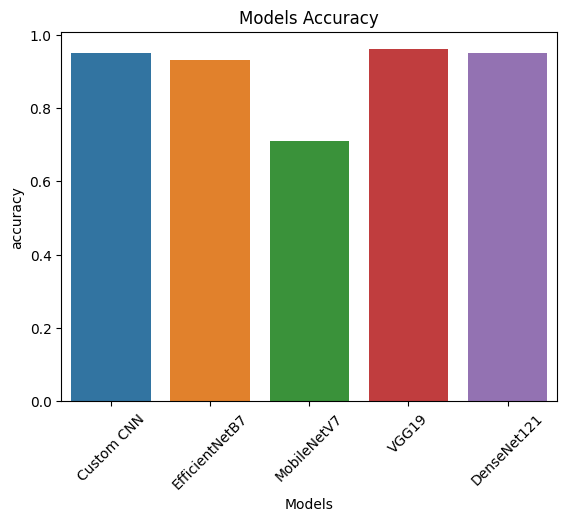

In [563]:
sns.barplot(data=results, x=results.index, y='accuracy')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Accuracy")
plt.show()

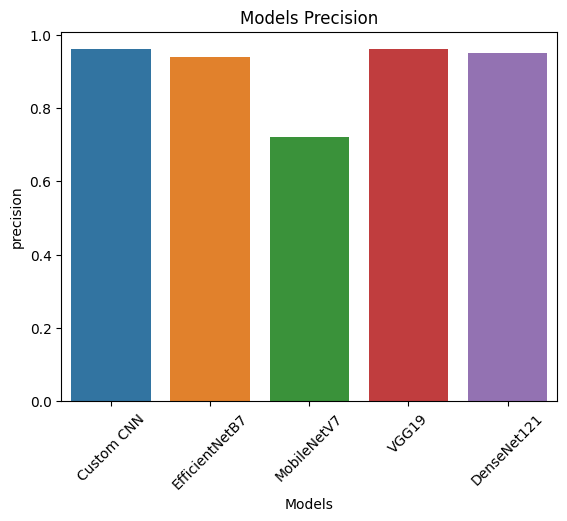

In [564]:
sns.barplot(data=results, x=results.index, y='precision')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Precision")
plt.show()

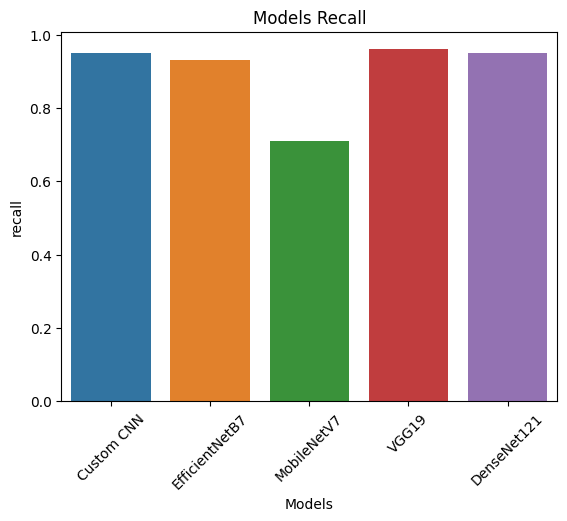

In [565]:
sns.barplot(data=results, x=results.index, y='recall')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models Recall")
plt.show()

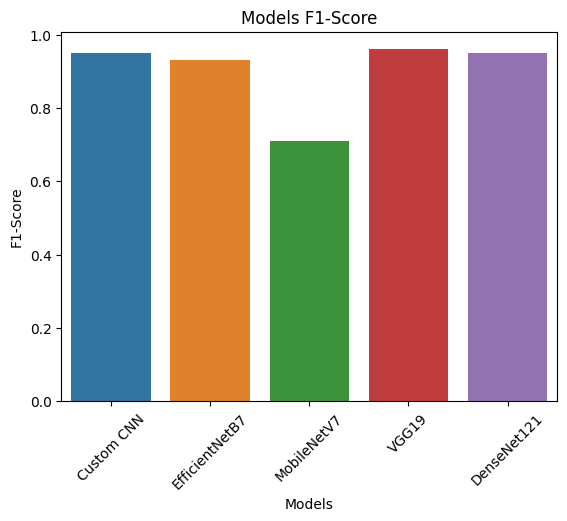

In [566]:
sns.barplot(data=results, x=results.index, y='F1-Score')
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.title("Models F1-Score")
plt.show()

**- `VGG19` shows an outstanding performance amongst all models.**

**- Due technical reasons in the next section `Post-processing`, it shows that `DenseNet121` has better performance than `VGG19` on external images, which will be used.**

**- The `Custom CNN` shows an excellent performance on the testing set on few number of epochs, it can be enhanced with more epochs and maybe data augmentation**

# 6) Post-Processing
#### **THIS SECTION IS ABOUT `Computer Vision` TECHNIQUES**

*the image will be taken from the user/externally to be processed and input into our model. some **LOW LEVEL COMPUTER VISION TECHNIQUES** are used in order to enhance the input image, wheter it is text or handwritten, these techniques are the following:*

- **Binarization:** The binarization function applies Otsu's binarization to the grayscale image, producing a binary image.

- **Dilate:** The dilate function performs morphological dilation on the binary image. The degree of dilation is adjusted based on whether processing `words` or `characters`.

- **Find Rectangles:** The find_rect function identifies bounding rectangles in the binary image, sorting them based on their **x-coordinate (From Left-to-Right)**.

- **Extract Characters:** The extract function uses the aforementioned techniques to extract characters from the image. It identifies words **FIRST**, then extracts characters from each word, and with the use of the pre-trained deep learning model to recognize each character.

In [588]:
# Computer Vision - Low level techniques
def load_model():
    model_path = '/kaggle/working/DenseNet121_model.h5'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])

## 6.1) Testing

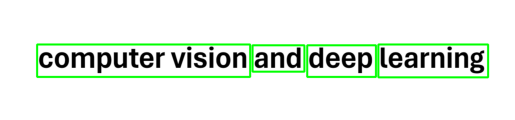

--> computervision and deep learning


In [585]:
# Testing 1
img = read_image('/kaggle/input/myimage16/Screenshot 2023-12-19 024132.png')
text = extract(img)
print('-->',text)

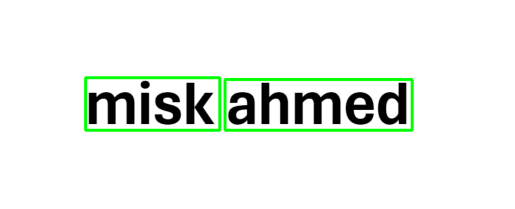

--> misk ahmed


In [589]:
# Testing 2
img2 = read_image('/kaggle/input/myimage15/Screenshot 2023-12-19 023610.png')
text = extract(img2)
print('-->',text)

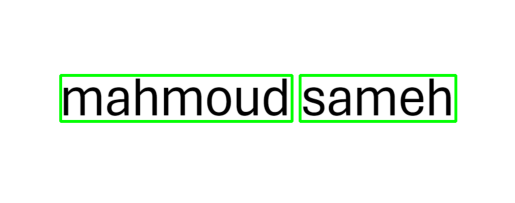

--> mahmoud sameh


In [590]:
# Testing 3
img3 = read_image('/kaggle/input/myimage12/Screenshot 2023-12-19 021326.png')
text = extract(img3)
print('-->',text)

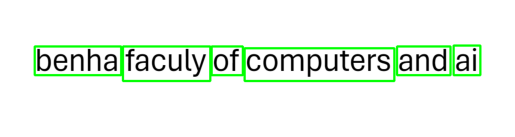

--> benha faculv of computers and ai


In [591]:
# Testing 4
img4 = read_image('/kaggle/input/myimage8/Screenshot 2023-12-19 011000.png')
text = extract(img4)
print('-->',text)

# 7) Conclusion
*This OCR implementation combines low-level computer vision techniques with deep learning for character recognition. The functions provided can be customized or extended for specific use cases, making it a versatile tool for text extraction from images.*

# END OF THE NOTEBOOK